In [1]:
import matplotlib.pyplot as plt

from mlxtend.data import loadlocal_mnist
import platform

In [2]:
X_train, y_train = loadlocal_mnist(
    images_path='data/train-images-idx3-ubyte', 
    labels_path='data/train-labels-idx1-ubyte')
X_test, y_test = loadlocal_mnist(
    images_path='data/t10k-images-idx3-ubyte', 
    labels_path='data/t10k-labels-idx1-ubyte')

Text(0.5, 1.0, '5')

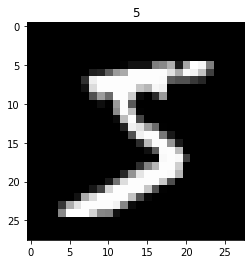

In [3]:
X_train.shape
plt.imshow(X_train[0].reshape(28, 28), cmap="gray")
plt.title(y_train[0])

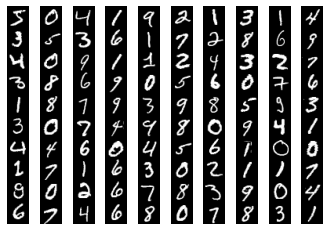

In [4]:
fig, axs = plt.subplots(10, 10) # figsize(20, 20)

for row in range(10):
    for col in range(10):
        axs[row][col].imshow(X_train[row * 10 + col].reshape(28, 28), cmap="gray")
        axs[row][col].axis("off")

plt.subplots_adjust(wspace=-0.2, hspace=0)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
BATCH_SIZE = 64         # number of data points in each batch
N_EPOCHS = 100           # times to run the model on complete data
INPUT_DIM = 28 * 28     # size of each input
HIDDEN_DIM = 256        # hidden dimension
LATENT_DIM = 75         # latent vector dimension
N_CLASSES = 10          # number of classes in the data
lr = 1e-3               # learning rate

In [8]:
def idx2onehot(idx, n=N_CLASSES):

    assert idx.shape[1] == 1
    assert torch.max(idx).item() < n

    onehot = torch.zeros(idx.shape[0], n)
#     onehot.scatter_(1, idx.data, torch.tensor(1).type(torch.int64))
    
    for i in range(idx.shape[0]):
        onehot[i, idx[i].item()] = 1

    return onehot

In [9]:
X_train = torch.tensor(X_train / 255, dtype=torch.float64)
y_train = torch.tensor(y_train).reshape(X_train.shape[0], 1)
# y_train = idx2onehot(y_train)
X_test = torch.tensor(X_test / 255, dtype=torch.float64)
y_test = torch.tensor(y_test).reshape(X_test.shape[0], 1)
# y_test = idx2onehot(y_test)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([60000, 784]) torch.Size([60000, 1])
torch.Size([10000, 784]) torch.Size([10000, 1])


In [10]:
train_data = []
for i in range(len(X_train)):
   train_data.append([X_train[i], y_train[i]])

test_data = []
for i in range(len(X_train)):
   test_data.append([X_train[i], y_train[i]])

In [11]:
train_iterator = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
class Encoder(nn.Module):
    ''' This the encoder part of VAE

    '''
    def __init__(self, input_dim, hidden_dim, latent_dim, n_classes):
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            latent_dim: A integer indicating the latent size.
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()

        self.linear = nn.Linear(input_dim + n_classes, hidden_dim)
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        # x is of shape [batch_size, input_dim + n_classes]

        hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]

        # latent parameters
        mean = self.mu(hidden)
        # mean is of shape [batch_size, latent_dim]
        log_var = self.var(hidden)
        # log_var is of shape [batch_size, latent_dim]

        return mean, log_var

In [13]:
class Decoder(nn.Module):
    ''' This the decoder part of VAE

    '''
    def __init__(self, latent_dim, hidden_dim, output_dim, n_classes):
        '''
        Args:
            latent_dim: A integer indicating the latent size.
            hidden_dim: A integer indicating the size of hidden dimension.
            output_dim: A integer indicating the size of output (in case of MNIST 28 * 28).
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()

        self.latent_to_hidden = nn.Linear(latent_dim + n_classes, hidden_dim)
        self.hidden_to_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x is of shape [batch_size, latent_dim + num_classes]
        x = F.relu(self.latent_to_hidden(x))
        # x is of shape [batch_size, hidden_dim]
        generated_x = torch.sigmoid(self.hidden_to_out(x))
        # x is of shape [batch_size, output_dim]

        return generated_x

In [14]:
class CVAE(nn.Module):
    ''' This the VAE, which takes a encoder and decoder.

    '''
    def __init__(self, input_dim, hidden_dim, latent_dim, n_classes):
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            latent_dim: A integer indicating the latent size.
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, n_classes)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, n_classes)

    def forward(self, x, y):

        x = torch.cat((x, y), dim=1)

        # encode
        z_mu, z_var = self.encoder(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)

        z = torch.cat((x_sample, y), dim=1)

        # decode
        generated_x = self.decoder(z)

        return generated_x, z_mu, z_var

In [15]:
# model
model = CVAE(INPUT_DIM, HIDDEN_DIM, LATENT_DIM, N_CLASSES).type(torch.float64)

#optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [16]:
def calculate_loss(x, reconstructed_x, mean, log_var):
    # reconstruction loss
    RCL = F.binary_cross_entropy(reconstructed_x, x, size_average=False)
    # kl divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return RCL + KLD

In [17]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0

    for i, (x, y) in enumerate(train_iterator):
        # reshape the data into [batch_size, 784]
        x = x.view(-1, 28 * 28)
        x = x.to(device)

        # convert y into one-hot encoding
        y = idx2onehot(y.view(-1, 1))
        y = y.to(device)

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        reconstructed_x, z_mu, z_var = model(x, y)

        # loss
        loss = calculate_loss(x, reconstructed_x, z_mu, z_var)

        # backward pass
        loss.backward()
        train_loss += loss.item()

        # update the weights
        optimizer.step()

    return train_loss

In [18]:
def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for i, (x, y) in enumerate(test_iterator):
            # reshape the data
            x = x.view(-1, 28 * 28)
            x = x.to(device)

            # convert y into one-hot encoding
            y = idx2onehot(y.view(-1, 1))
            
            y = y.to(device)

            # forward pass
            reconstructed_x, z_mu, z_var = model(x, y)

            # loss
            loss = calculate_loss(x, reconstructed_x, z_mu, z_var)
            test_loss += loss.item()

    return test_loss

In [19]:
train_losses = []
test_losses = []

for e in range(N_EPOCHS):

    train_loss = train()
    test_loss = test()

    train_loss /= len(X_train)
    train_losses.append(train_loss)
    test_loss /= len(X_test)
    test_losses.append(test_loss)

    print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0, Train Loss: 159.35, Test Loss: 776.09
Epoch 1, Train Loss: 121.31, Test Loss: 694.47
Epoch 2, Train Loss: 112.79, Test Loss: 665.07
Epoch 3, Train Loss: 109.31, Test Loss: 648.79
Epoch 4, Train Loss: 107.25, Test Loss: 637.74
Epoch 5, Train Loss: 105.92, Test Loss: 630.93
Epoch 6, Train Loss: 104.93, Test Loss: 625.68
Epoch 7, Train Loss: 104.23, Test Loss: 623.43
Epoch 8, Train Loss: 103.65, Test Loss: 619.14
Epoch 9, Train Loss: 103.20, Test Loss: 618.09
Epoch 10, Train Loss: 102.85, Test Loss: 615.27
Epoch 11, Train Loss: 102.50, Test Loss: 612.87
Epoch 12, Train Loss: 102.20, Test Loss: 612.42
Epoch 13, Train Loss: 101.99, Test Loss: 609.98
Epoch 14, Train Loss: 101.76, Test Loss: 609.30
Epoch 15, Train Loss: 101.55, Test Loss: 608.04
Epoch 16, Train Loss: 101.38, Test Loss: 606.76
Epoch 17, Train Loss: 101.21, Test Loss: 606.75
Epoch 18, Train Loss: 101.03, Test Loss: 605.81
Epoch 19, Train Loss: 100.92, Test Loss: 604.21
Epoch 20, Train Loss: 100.80, Test Loss: 605.34
Ep

In [20]:
train_losses = []
test_losses = []

for e in range(N_EPOCHS):

    train_loss = train()
    test_loss = test()

    train_loss /= len(X_train)
    train_losses.append(train_loss)
    test_loss /= len(X_test)
    test_losses.append(test_loss)

    print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

Epoch 0, Train Loss: 97.46, Test Loss: 583.86
Epoch 1, Train Loss: 97.44, Test Loss: 582.98
Epoch 2, Train Loss: 97.43, Test Loss: 585.34
Epoch 3, Train Loss: 97.39, Test Loss: 583.87
Epoch 4, Train Loss: 97.33, Test Loss: 583.77
Epoch 5, Train Loss: 97.33, Test Loss: 583.06
Epoch 6, Train Loss: 97.37, Test Loss: 583.76
Epoch 7, Train Loss: 97.33, Test Loss: 582.76
Epoch 8, Train Loss: 97.26, Test Loss: 582.07
Epoch 9, Train Loss: 97.27, Test Loss: 582.44
Epoch 10, Train Loss: 97.26, Test Loss: 582.79
Epoch 11, Train Loss: 97.20, Test Loss: 581.43
Epoch 12, Train Loss: 97.18, Test Loss: 582.43
Epoch 13, Train Loss: 97.18, Test Loss: 582.46
Epoch 14, Train Loss: 97.17, Test Loss: 582.22
Epoch 15, Train Loss: 97.15, Test Loss: 581.89
Epoch 16, Train Loss: 97.17, Test Loss: 581.85
Epoch 17, Train Loss: 97.13, Test Loss: 581.97
Epoch 18, Train Loss: 97.13, Test Loss: 581.89
Epoch 19, Train Loss: 97.14, Test Loss: 582.72
Epoch 20, Train Loss: 97.06, Test Loss: 581.97
Epoch 21, Train Loss: 9

In [21]:
torch.tensor([1]).view(-1, 1).shape

torch.Size([1, 1])

In [22]:
gen_images = []

for digit in range(10):
    for num in range(10):
        # sample and generate a image
        y = idx2onehot(torch.tensor([digit]).view(-1, 1))
        z = torch.cat((torch.randn(1, LATENT_DIM), y), dim=1).to(device).type(torch.float64)

        # run only the decoder
        reconstructed_img = model.decoder(z)
        gen_images.append(reconstructed_img.detach().numpy())

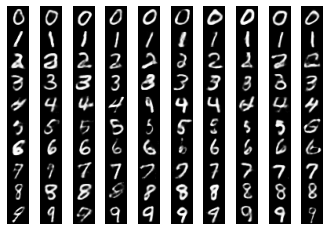

In [23]:
fig, axs = plt.subplots(10, 10) # figsize(20, 20)

for row in range(10):
    for col in range(10):
        axs[row][col].imshow(gen_images[row * 10 + col].reshape(28, 28), cmap="gray")
        axs[row][col].axis("off")

plt.subplots_adjust(wspace=-0.2, hspace=0)

In [ ]:
# https://ravirajag.dev/machine%20learning/data%20science/deep%20learning/generative/neural%20network/encoder/variational%20autoencoder/2019/03/04/conditionalvae.html